# Data Analytics 

## Prediction of fullblooded horses' value basing on parent matching

Authors: 

Michał Motyl
Kamil Pieprzycki

### Problem describtion
cos tam cos tam



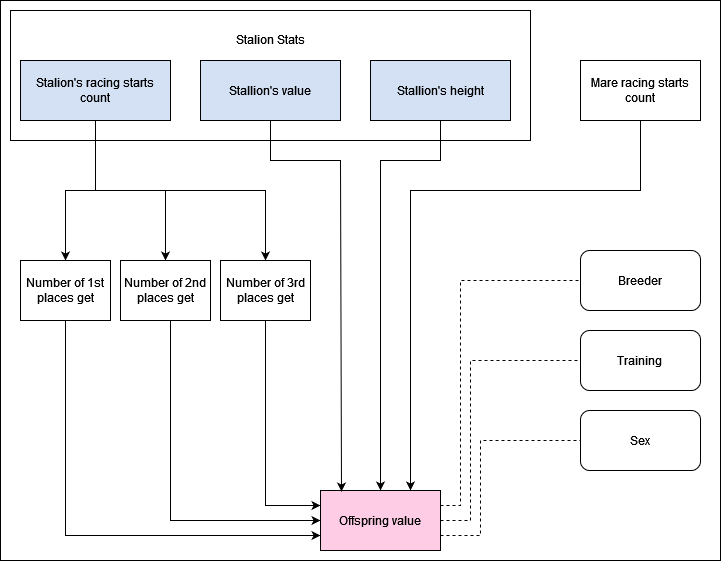

In [308]:
from PIL import Image
image = Image.open("offspring.png")
display(image)

In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from cmdstanpy import CmdStanModel
from cmdstanpy import install_cmdstan
 
install_cmdstan()

Installing CmdStan version: 2.32.2
Install directory: /root/.cmdstan
CmdStan version 2.32.2 already installed


True

## Data preparation

In [199]:
# imports
path_to_prep_mum = 'data/data_prepared/mums_prep.csv'
path_to_prep_dad = 'data/data_prepared/dads_prep.csv'
df_dads = pd.read_csv(path_to_prep_dad)
df_dads['dad_value_numeric_rescale'] = df_dads.dad_value_numeric /10**6


path_to_prepared_data = 'data/data_prepared/only_stalions_prepared.csv'
df = pd.read_csv(path_to_prepared_data)
df.head()

,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts
0,0,1,D1,S2,132570.0,8,156410.0,9.0,1.0,0.0,10.0
1,2,3,D1,S3,631605.0,11,1749869.0,43.0,8.0,5.0,66.0
2,3,4,D1,S4,8963.0,1,580806.0,14.0,2.0,2.0,18.0
3,4,5,D1,S4,4799.0,1,580806.0,14.0,2.0,2.0,18.0
4,7,58,D9,S5,209211.0,14,1176781.0,21.0,7.0,3.0,32.0


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         40 non-null     int64  
 1   kid_id             40 non-null     int64  
 2   mum_id             40 non-null     object 
 3   dad_id             40 non-null     object 
 4   value_numeric      40 non-null     float64
 5   first_place        40 non-null     int64  
 6   dad_value_numeric  40 non-null     float64
 7   dad_first_place    40 non-null     float64
 8   dad_second_place   40 non-null     float64
 9   dad_third_place    40 non-null     float64
 10  dad_num_of_starts  40 non-null     float64
dtypes: float64(6), int64(3), object(2)
memory usage: 3.6+ KB


In [201]:
# rescaling values
df_copy = df.copy()
# for column in ['value_numeric', 'dad_value_numeric']:
#     new_col = column + '_rescale'
#     df_copy[new_col] = df[column]/10**6

columns_to_rescale = ['first_place', 'dad_first_place', 'dad_second_place', 'dad_third_place', 'value_numeric', 'dad_value_numeric', 'dad_num_of_starts']
df_copy[columns_to_rescale] -= df[columns_to_rescale].min()
df_copy[columns_to_rescale] /= df[columns_to_rescale].max()
df_copy.head()

,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts
0,0,1,D1,S2,0.097268,0.5000,0.089384,0.209302,0.111111,0.0,0.151515
1,2,3,D1,S3,0.469653,0.6875,1.000000,1.000000,0.888889,1.0,1.000000
2,3,4,D1,S4,0.005032,0.0625,0.331914,0.325581,0.222222,0.4,0.272727
3,4,5,D1,S4,0.001924,0.0625,0.331914,0.325581,0.222222,0.4,0.272727
4,7,58,D9,S5,0.154459,0.8750,0.672497,0.488372,0.777778,0.6,0.484848


## histogram of data we want to predict

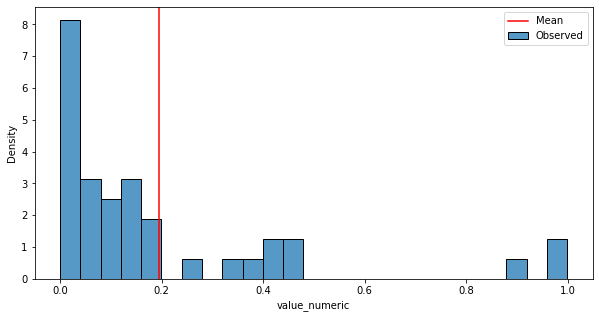

0.19465777732673586
0.2612924559240941


In [202]:
# analysis of value: what we want to to predict
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_copy, x='value_numeric', bins=25, ax=axs, label='Observed',stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='red', label='Mean')
graph.legend()
plt.show()
print(df_copy.value_numeric.mean())
print(df_copy.value_numeric.std())

Calculting values for later basic ppc stan model

In [203]:
# mu_basic = log_maker(df_copy.value_numeric.mean(),df_copy.value_numeric.std())
# print(mu_basic)

## histograms of data we want to predict from


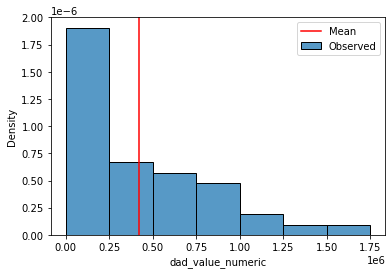

In [204]:
# histograms of data we want to predict from
graph = sns.histplot(data=df_dads, x='dad_value_numeric', label='Observed', stat='density')
graph.axvline(df_dads.dad_value_numeric.mean(), color='red', label='Mean')
graph.legend()
plt.show()

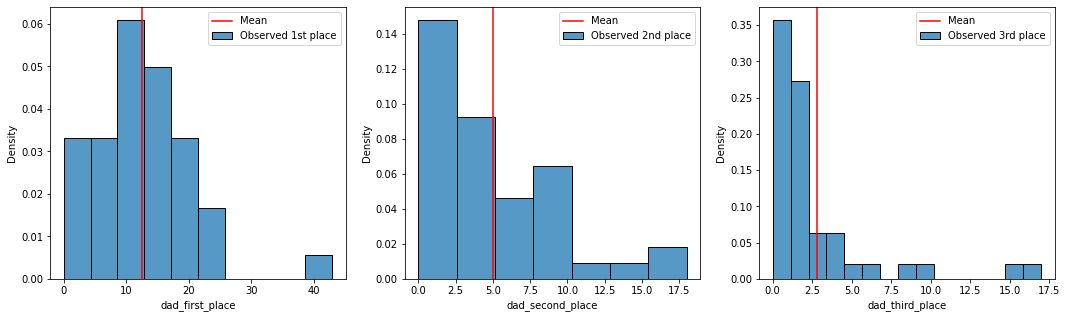

In [205]:
# places of dad
fig, axs = plt.subplots(1,3, figsize=(18,5))
graph = sns.histplot(data=df_dads, x='dad_first_place', label='Observed 1st place', ax=axs[0], stat='density')
graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')
graph.legend()

graph = sns.histplot(data=df_dads, x='dad_second_place', label='Observed 2nd place', ax=axs[1], stat='density')
graph.axvline(df_dads.dad_second_place.mean(), label='Mean', color='red')
graph.legend()

graph = sns.histplot(data=df_dads, x='dad_third_place', label='Observed 3rd place', ax=axs[2], stat='density')
graph.axvline(df_dads.dad_third_place.mean(), label='Mean', color='red')
graph.legend()
plt.show()

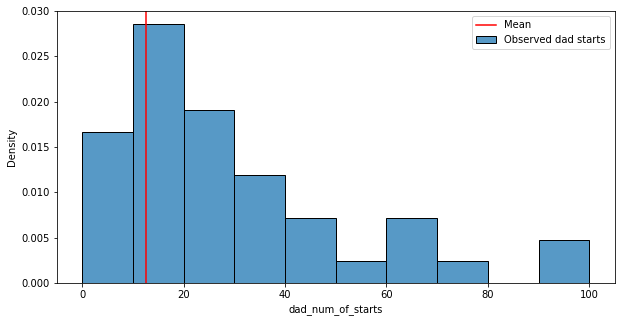

In [206]:
# nums of starts
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_dads, x='dad_num_of_starts', label='Observed dad starts', ax=axs, bins=10, stat='density')
graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')
graph.legend()
plt.show()


Assumed prior distributions:
- `dad_num_of_starts` : lognormal
- `dad_value_numeric_rescale` : exponential
- `dad_first_place` : lognormal
- `dad_second_place` : exponential
- `dad_third_place` : expnoential

In [207]:
def log_maker(mu,sigma):
    log_mu = np.log((mu**2)/np.sqrt(mu**2 + sigma**2))    
    log_sigma = np.sqrt(np.log(1+(sigma**2 )/(mu**2)))
    return log_mu,log_sigma

# calculating needed parameters for prior distributions
# to use in stan models in a bit

# rescaling df_dads before calculations
columns_to_rescale = ['dad_first_place', 'dad_second_place', 'dad_third_place', 'dad_value_numeric', 'dad_num_of_starts']
df_dads_copy = df_dads.copy()
df_dads_copy[columns_to_rescale] -= df_dads_copy[columns_to_rescale].min()
df_dads_copy[columns_to_rescale] /= df_dads_copy[columns_to_rescale].max()

# dad_num_of_starts
mu_dad_num_of_starts, sigma_dad_num_of_starts = log_maker(df_dads_copy.dad_num_of_starts.mean(),df_dads_copy.dad_num_of_starts.std())
# mu_dad_num_of_starts = df_dads.dad_num_of_starts.mean()
# sigma_dad_num_of_starts = df_dads.dad_num_of_starts.std()

# dad_value_numeric_rescale
lambda_dad_value_numeric_rescale = 1/df_dads_copy.dad_value_numeric_rescale.mean()

# dad_first_place
mu_dad_first_place, sigma_dad_first_place = log_maker(df_dads_copy.dad_first_place.mean(),df_dads_copy.dad_first_place.std())
# mu_dad_first_place = df_dads.dad_first_place.mean()
# sigma_dad_first_place = df_dads.dad_first_place.std()

# dad_second_place
lambda_dad_second_place = 1/df_dads_copy.dad_second_place.mean()

# dad_third_place
lambda_dad_third_place = 1/df_dads_copy.dad_third_place.mean()

data = {
        'mu_dad_num_of_starts': mu_dad_num_of_starts,
        'sigma_dad_num_of_starts': sigma_dad_num_of_starts,
        'mu_dad_first_place': mu_dad_first_place,
        "sigma_dad_first_place": sigma_dad_first_place,
        "lambda_dad_value_numeric_rescale": lambda_dad_value_numeric_rescale,
        "lambda_dad_second_place": lambda_dad_second_place,
        "lambda_dad_third_place": lambda_dad_third_place,        
}

print(data)


{'mu_dad_num_of_starts': -1.481740170128063, 'sigma_dad_num_of_starts': 0.7122777747804101, 'mu_dad_first_place': -1.4063011487708954, 'sigma_dad_first_place': 0.5909855553824085, 'lambda_dad_value_numeric_rescale': 2.370540413791375, 'lambda_dad_second_place': 3.5999999999999996, 'lambda_dad_third_place': 6.102564102564102}


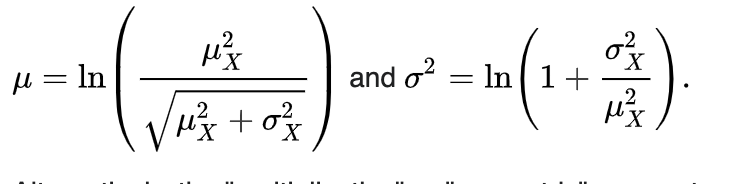

In [209]:
with open('models/distribution_check.stan') as file:
    print(file.read())
    file.close()

data {
    real mu_dad_num_of_starts;
    real sigma_dad_num_of_starts;
    real mu_dad_first_place;
    real sigma_dad_first_place;
    real lambda_dad_value_numeric_rescale;
    real lambda_dad_second_place;
    real lambda_dad_third_place;
}

generated quantities {
    real<lower=0> first_place = lognormal_rng(mu_dad_first_place, sigma_dad_first_place); 
    real<lower=0> num_of_start= lognormal_rng(mu_dad_num_of_starts, sigma_dad_num_of_starts);
    real<lower=0> value_numeric= exponential_rng(lambda_dad_value_numeric_rescale);
    real<lower=0> second_place = exponential_rng(lambda_dad_second_place);
    real<lower=0> third_place = exponential_rng(lambda_dad_third_place);
    
    real kid_value = exponential_rng(1/num_of_start);
}

// data {
//     real mu_dad_num_of_starts;
//     real sigma_dad_num_of_starts;
//     real mu_dad_first_place;
//     real sigma_dad_first_place;
//     real lambda_dad_value_numeric_rescale;
//     real lambda_dad_second_place;
//     real lambda_da

## Checking distribution model for data simulation

In [210]:
m_distribution_check=CmdStanModel(stan_file='models/distribution_check.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [211]:
data = {
        'mu_dad_num_of_starts': mu_dad_num_of_starts,
        'sigma_dad_num_of_starts': sigma_dad_num_of_starts,
        'mu_dad_first_place': mu_dad_first_place,
        
        "sigma_dad_first_place": sigma_dad_first_place,
        "lambda_dad_value_numeric_rescale": lambda_dad_value_numeric_rescale,
        "lambda_dad_second_place": lambda_dad_second_place,
        "lambda_dad_third_place": lambda_dad_third_place,
        
}


sim1_distribution_check=m_distribution_check.sample(data=data, seed=26062023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [212]:
ppc_distribution_chceck = sim1_distribution_check.draws_pd()
ppc_distribution_chceck.head()


,lp__,accept_stat__,first_place,num_of_start,value_numeric,second_place,third_place,kid_value
0,0.0,0.0,0.248393,0.114438,0.098246,0.365381,0.144113,0.065300
1,0.0,0.0,0.243103,0.077203,0.522891,0.433563,0.340484,0.075279
2,0.0,0.0,0.251015,0.058017,0.216147,0.646471,0.412611,0.010580
3,0.0,0.0,0.121003,0.186828,0.616947,0.201995,0.286595,0.113712
4,0.0,0.0,0.137864,0.685426,0.175233,0.055482,0.031021,1.649290


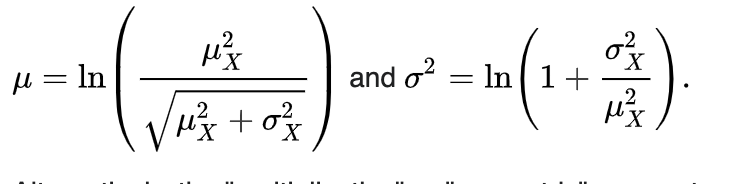

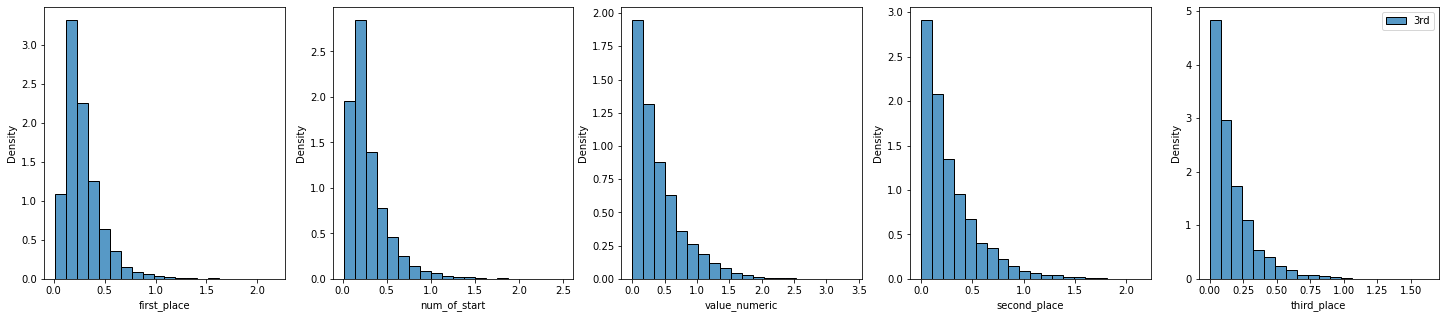

In [213]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['first_place']<100], x='first_place', label='Observed starts', ax=axs[0],bins=20,stat='density')

# graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')

graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['num_of_start']<100], x='num_of_start', label='Observed starts', ax=axs[1],bins=20,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['value_numeric']<100], x='value_numeric', label='value_numeric', ax=axs[2],bins=20,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['second_place']<100], x='second_place', label='2nd', ax=axs[3],bins=20,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['third_place']<100], x='third_place', label='3rd', ax=axs[4],bins=20,stat='density')

graph.legend()
plt.show()

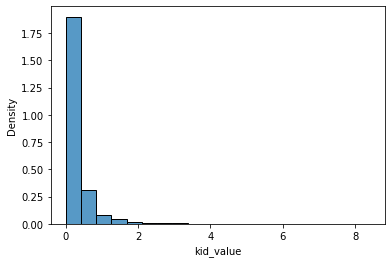

In [214]:

graph = sns.histplot(data=ppc_distribution_chceck, x='kid_value', label='Kid_value' ,bins=20 ,stat='density')

# Model 1 describtion 
1. The exponential distribution was chosen as the first model for predicting offspring values, as it was deemed the most suitable for our case.
2. The chosen distribution is suitable because the majority of horses being sold are priced lower, as it is an auction market and we do not assume any upper limits. Moreover, it should be noted that cases of expensive horses are very rare.
3. spośród wszystkich zmiennych poprzez eksplorację danych zawężono zbiór danych wejściowych do 5 zmiennych:
    - `dad_num_of_starts` - opisy
    - `dad_value_numeric_rescale`
    - `dad_first_place`
    - `dad_second_place`
    - `dad_third_place`

wzorki 
$$ output_{value} \sim Exponetial(\lambda) $$

$$ \lambda = predictor_i \cdot \beta + \alpha_0$$

Where: 

- delta cos tam - 
- lambda cos tam - 
- beta - 



# Pior Predictive check - Model 1

In [257]:
model_basic=CmdStanModel(stan_file='models/model_basic.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/model_basic.stan to exe file /home/racehorse_bayes/models/model_basic


INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/model_basic


In [258]:
R = 1000
sim_model_basic=model_basic.sample(iter_sampling=R,
                     iter_warmup=50,
                     chains=1,
                     fixed_param=True,
                     refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [259]:
basic_model_df = sim_model_basic.draws_pd()
basic_model_df.head()

,lp__,accept_stat__,value,num_of_starts,first_place,second_place,third_place,a0,a1,value_coeff,num_of_starts_coeff,first_place_coeff,second_place_coeff,third_place_coeff,mu,kid_value
0,0.0,0.0,0.307023,0.263037,0.151405,0.032521,0.252687,0.188055,0.122240,0.188538,0.370619,0.297014,0.304611,0.310140,0.177221,0.077850
1,0.0,0.0,0.747699,0.105538,0.203142,0.462405,0.000384,0.179139,0.556429,0.183213,0.417643,0.299526,0.300714,0.298474,0.001899,0.004002
2,0.0,0.0,0.127989,0.147718,0.630938,0.124006,0.170623,0.155534,0.504470,0.200646,0.410766,0.304463,0.303523,0.300226,0.009197,0.019272
3,0.0,0.0,0.305705,0.210601,0.065424,0.457069,0.033712,0.097977,0.283625,0.208070,0.387878,0.304113,0.293847,0.305026,0.062073,0.002074
4,0.0,0.0,0.287080,0.281398,0.150766,0.395480,0.339505,0.267896,0.183689,0.179052,0.410339,0.299525,0.303334,0.269091,0.253783,0.264989


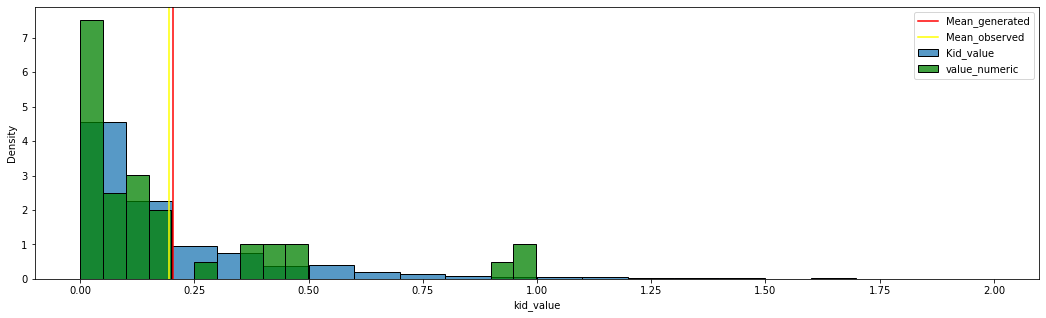

In [262]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
graph = sns.histplot(data=basic_model_df, x='kid_value',ax=axs,bins=20, label='Kid_value' ,stat='density')
graph.axvline(basic_model_df.kid_value.mean(), color='red', label='Mean_generated')
graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='yellow', label='Mean_observed')
graph.legend()


The very basic model ma sens xD
mozna go rozwinąć 
popraw potem Kamil


# Posterior Check - MODEL 1 

In [281]:
import arviz as az


In [301]:
fit_model_1=CmdStanModel(stan_file='models/model_ppc_ver2.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/model_ppc_ver2.stan to exe file /home/racehorse_bayes/models/model_ppc_ver2


INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/model_ppc_ver2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/racehorse_bayes/models/model_ppc_ver2.hpp /home/racehorse_bayes/models/model_ppc_ver2.stan
Warning in '/home/racehorse_bayes/models/model_ppc_ver2.stan', line 25, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/racehorse_bayes/models/model_ppc_ver2.stan', line 67, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-igno

In [302]:
data = { 'N': len(df_copy),
        'dad_value_numeric': df_copy['dad_value_numeric'].values,
        'dad_num_of_starts': df_copy.dad_num_of_starts,
        'dad_first_place': df_copy.dad_first_place,
        'dad_second_place': df_copy.dad_second_place,
        'dad_third_place': df_copy.dad_third_place,
        'kid_value': df_copy.value_numeric.values }

fit1=fit_model_1.sample(data=data, seed=69420)



INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [303]:
az.summary(fit1, var_names=['mu'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu[0],0.16,0.03,0.11,0.21
mu[1],0.48,0.03,0.43,0.53
mu[2],0.23,0.03,0.18,0.28
mu[3],0.23,0.03,0.18,0.28
mu[4],0.33,0.03,0.29,0.39
mu[5],0.31,0.03,0.26,0.35
mu[6],0.13,0.03,0.09,0.18
mu[7],0.13,0.03,0.09,0.18
mu[8],0.13,0.03,0.09,0.18
mu[9],0.13,0.03,0.09,0.18


In [304]:
predicted_df = fit1.draws_pd()
predicted_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a0,a1,value_coeff,...,log_likelihood[31],log_likelihood[32],log_likelihood[33],log_likelihood[34],log_likelihood[35],log_likelihood[36],log_likelihood[37],log_likelihood[38],log_likelihood[39],log_likelihood[40]
0,10.57940,0.992370,0.499184,3.0,7.0,0.0,-7.31875,0.399715,0.074425,0.212102,...,0.732767,1.11894,1.94787,0.872006,-2.93940,0.588783,1.64879,0.681142,1.35408,1.23028
1,10.79430,1.000000,0.499184,3.0,7.0,0.0,-9.49587,0.612129,0.083533,0.186869,...,0.667415,1.01179,1.65789,0.901232,-2.31538,0.538257,1.43786,0.625751,1.20203,1.09731
2,9.62536,0.988976,0.499184,3.0,7.0,0.0,-8.04074,0.653310,0.221403,0.206748,...,0.682678,1.03609,1.77778,0.905191,-2.50814,0.554795,1.51899,0.644458,1.25232,1.14167
3,7.63775,0.920969,0.499184,3.0,7.0,0.0,-5.04265,0.356421,0.023027,0.200492,...,0.755246,1.15797,1.95760,0.872945,-3.03268,0.598624,1.66681,0.692929,1.38046,1.25297
4,10.75550,0.942771,0.499184,3.0,7.0,0.0,-5.24533,0.514859,0.055696,0.191806,...,0.693513,1.05359,1.74641,0.906261,-2.52054,0.558103,1.50732,0.646268,1.25640,1.14525


In [305]:
predicted_df['mean_kid_value_pred'] =predicted_df.loc[:, "kid_value_p[1]":f"kid_value_p[{len(df_copy)}]"].mean(axis=1)
predicted_df['mean_mu'] = predicted_df.loc[:, "mu[1]":f"mu[{len(df_copy)}]"].mean(axis=1)

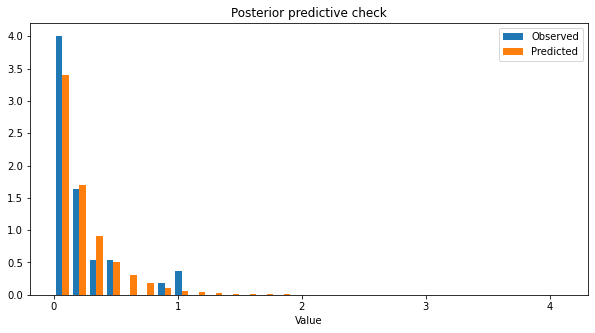

In [306]:
plt.figure(figsize=(10, 5))
predicted = predicted_df.loc[:, "kid_value_p[1]":f"kid_value_p[{len(df_copy)}]"].values.reshape(-1)
#predicted = ppc_df1["life_expectancy[1]"]
plt.hist([df_copy["value_numeric"], predicted], bins=30, density=True)
plt.xlabel("Value")
plt.title("Posterior predictive check")
plt.legend(["Observed", "Predicted"])
plt.show()

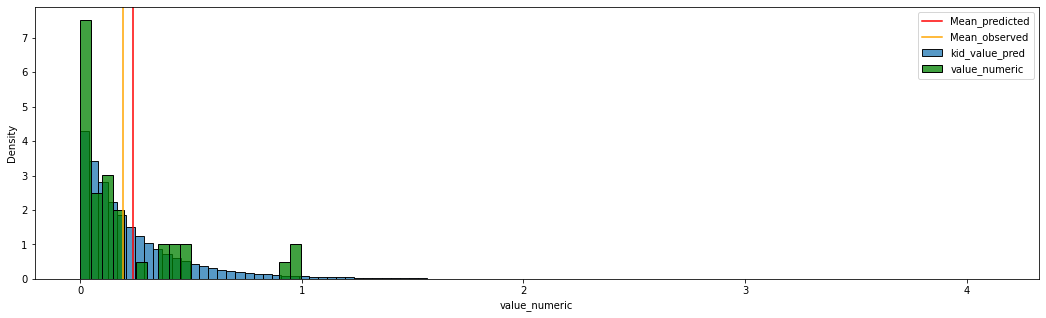

In [307]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
predicted = predicted_df.loc[:, "kid_value_p[1]":f"kid_value_p[{len(df_copy)}]"].values.reshape(-1)
graph = sns.histplot(data=predicted,ax=axs,bins=100, label='kid_value_pred',stat='density')
graph.axvline(predicted.mean(), color='red', label='Mean_predicted')
graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='orange', label='Mean_observed')
graph.legend()
# graph.set(xlim=(0,1))

jest sensownie mozna sie pokusic o zmiane prarametrow zeby średnia była blizej 
dlugi ogon to je chujnia 
powinno si eucinac bardziej z tylu
powiinno byc bardziej do gory
rozlozona metryka



poszukac modelu ktory schodzi jak exp ale wyplaszczaq sie wolniej

In [ ]:
log_maker(0.2,0.2)

(-1.956011502714073, 0.8325546111576977)